SVG文件已保存为 'power_curves.svg'


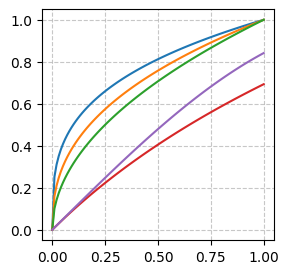

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 创建x值的数组
x = np.linspace(0, 1, 100)

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(3, 3))

# 绘制多条pow曲线
powers = [.3, .4, 0.5]
for power in powers:
    y = np.power(x, power)
    ax.plot(x, y, label=f'x^{power}')

# 设置图形标题和标签
# ax.set_title('Multiple Power Curves')
# ax.set_xlabel('x')
# ax.set_ylabel('y')

# 添加图例
# ax.legend()

# 添加网格线
ax.grid(True, linestyle='--', alpha=0.7)

# 保存为SVG格式
plt.savefig('power_curves.svg', format='svg', dpi=300, bbox_inches='tight')

print("SVG文件已保存为 'power_curves.svg'")

In [1]:
import torch as pt

mols_test = pt.load('./data/mine/test_11499.pt')
print(len(mols_test))
mols_test_rep = pt.load('./data/mine/test_11499_rep.pt')
print(len(mols_test_rep))
mols_all = pt.load('./data/mine/mols_all.pt')
print(len(mols_all))
extra10 = pt.load('./data/mine/extra10.pt')
print(len(extra10))

11499
11499
2253216
10


In [2]:
mass_lib = [float(mol.metadata['nominal_mass']) for mol in mols_all]
mass_test = [float(mol.metadata['nominal_mass']) for mol in mols_test]
mass_10 = [float(mol.metadata['nominal_mass']) for mol in extra10]

In [3]:
from torch.utils.data import DataLoader
from utils.data import SpecDataset, collate_fun_emb

dataset_test = SpecDataset(mols_test)
loader_test = DataLoader(dataset_test, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_lib = SpecDataset(mols_all)
loader_lib = DataLoader(dataset_lib, batch_size=2048, shuffle=False,
                        num_workers=8, collate_fn=collate_fun_emb)
dataset_extra10 = SpecDataset(extra10)
loader_extra10 = DataLoader(dataset_extra10, batch_size=10, shuffle=False,
                            num_workers=1, collate_fn=collate_fun_emb)

In [4]:
from utils.model import Spec2Emb

gpu=6
model = Spec2Emb().to(gpu)
model.load_state_dict(pt.load('./model/mass_before_ft_p0.4_epoch2.pth', map_location='cpu'))

<All keys matched successfully>

In [5]:
from utils.data import gen_embeddings, build_idx

embs_lib = gen_embeddings(model, loader_lib, gpu, power=0.4)
embs_test = gen_embeddings(model, loader_test, gpu, power=0.4) 
embs_10 = gen_embeddings(model, loader_extra10, gpu, power=0.4)
I, Dis = build_idx(embs_lib, embs_test, gpu)

Searching time:  0:00:01.590460


In [6]:
from copy import deepcopy


embs_lib_mass = deepcopy(embs_lib)
embs_test_mass = deepcopy(embs_test)
embs_10_mass = deepcopy(embs_10)
embs_lib_mass[:, -1] = mass_lib
embs_test_mass[:, -1] = mass_test
embs_10_mass[:, -1] = mass_10

In [7]:
I_10, Dis_10 = build_idx(embs_lib_mass, embs_10_mass, gpu)
for i in range(len(I_10)):
    print('compound:'+str(i+1))
    for j in range(len(I_10[i])):
        if mols_all[I_10[i][j]].metadata['inchikey'] == extra10[i].metadata['inchikey']:
            print('Rank:', j+1)
            break

Searching time:  0:00:00.017082
compound:1
Rank: 1
compound:2
Rank: 1
compound:3
Rank: 1
compound:4
Rank: 1
compound:5
Rank: 1
compound:6
Rank: 2
compound:7
Rank: 9
compound:8
Rank: 9
compound:9
Rank: 46
compound:10
Rank: 19


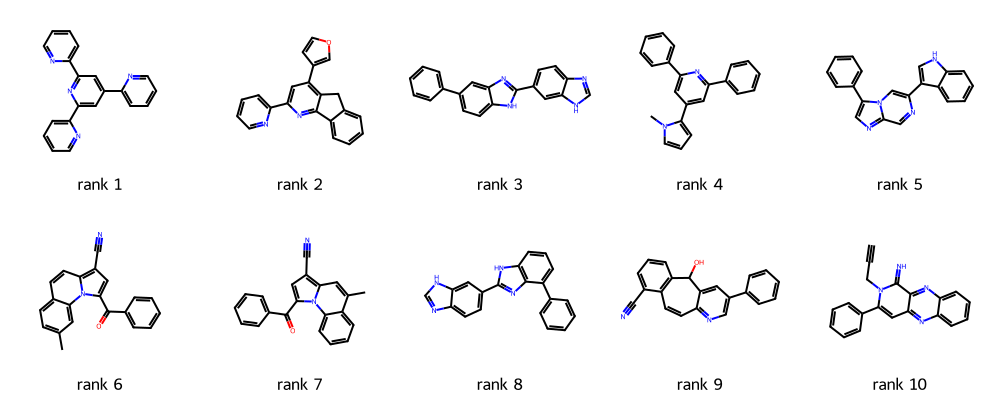

In [19]:
from rdkit import Chem
from rdkit.Chem import Draw

candidate_mols9 = [mols_all[I_10[8][i]] for i in range(10)]
candidate_smi9 = [mol.metadata['smiles'] for mol in candidate_mols9]
Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in candidate_smi9], molsPerRow=5, subImgSize=(200, 200), 
                     legends=[f'rank {i}' for i in range(1,11,1)], useSVG=True)

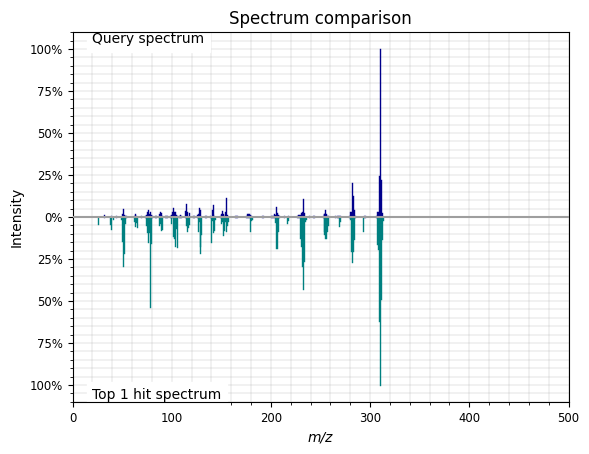

In [14]:
from matchms.plotting import plot_spectrum, plot_spectra_mirror
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot()
extra10[8].set('compound_name', 'Query spectrum')
candidate_mols9[0].set('compound_name', 'Top 1 hit spectrum')
ax = plot_spectra_mirror(extra10[8], candidate_mols9[0], ax=ax, max_mz=400.0)
fig.savefig('./picture/spec comp.svg', format='svg', dpi=500)

In [8]:
I_mass, Dis_mass = build_idx(embs_lib_mass, embs_test_mass, gpu)

Searching time:  0:00:01.582755
